In [1]:
from PIL import Image, ImageFilter, ImageEnhance
import numpy as np
from pathlib import Path
import random
import plotly.express as px
from scipy import ndimage
import math
from tqdm.auto import tqdm
import pandas as pd
import sqlite3

In [2]:
import sys
sys.path.append('../../30_data_tools/')

from helper import load_dotenv
from file_interaction import get_generic_image_filepath, open_img
from get_labelstudio_data import get_results_of_project

In [3]:
dotenv = load_dotenv()

In [4]:
TILE_SIZE = 280

In [5]:
def check_bbox_size( bbox_string ):
    vals = [int(val) for val in bbox_string.split(';')]

    return vals[2] >= TILE_SIZE and vals[3] >= TILE_SIZE

In [6]:
with sqlite3.connect( dotenv['DB_PATH'] ) as con:
    masks = pd.merge(
        pd.read_sql(
            'SELECT * FROM mask',
            con
        ),
        pd.DataFrame(
            [(r['id'],r['labels'][0])
             for r in get_results_of_project(2) if 'id' in r],
            columns=['mask_id','label']
        ),
        how="left",
        on='mask_id'
    )

masks.loc[
    masks.ssim > 0.95,
    'label'
] = 'checked_no_moire'

masks = masks.loc[
    pd.isna(masks.label) == False
]
masks = masks.loc[
    masks.bbox.apply( check_bbox_size )
]

# Funktionen

In [7]:
def get_fft( input_img ):
    ft = np.fft.ifftshift(np.array(input_img)[:,:,0])
    ft = np.fft.fft2(ft)
    ft = np.fft.fftshift(ft)
    
    return ft

def invert_fft (input_real, input_imaginary):
    input = (input_real + 1j * input_imaginary)
    ift = np.fft.ifftshift(input)
    ift = np.fft.ifft2(ift)
    ift = np.fft.fftshift(ift)
    return ift.real

In [8]:
def get_spherical_coordinate( x, y ):
    r = math.sqrt( x ** 2 + y ** 2 )
    angle = math.degrees(math.atan2(y,x))

    return r, angle

In [9]:
def get_carthesian_coordinate( r, angle ):
    x = r * math.cos(math.radians(angle))
    y = r * math.sin(math.radians(angle))
    return x, y

In [10]:
def limit_frequencies( fft, inner_limit=None, outer_limit=None ):
    center = (fft.shape[1] / 2, fft.shape[0] / 2)
    for y in range(fft.shape[0]):
        for x in range(fft.shape[1]):
            r = math.sqrt( abs(center[0] - x) ** 2 + abs(center[1] - y) ** 2 )
            
            if outer_limit is not None and r > outer_limit:
                fft[y,x] = 0
    
            if inner_limit is not None and r < inner_limit:
                fft[y,x] = 0

    return fft

In [11]:
def cut_into_tiles( img ):
    tiles = []
    y = 0
    x = 0

    if img.size[0] < TILE_SIZE or img.size[1] < TILE_SIZE:
        raise Exception("img smaller than tile size")

    while y < img.size[1]:
        start_x = x if x+TILE_SIZE < img.size[0] else img.size[0]-TILE_SIZE
        start_y = y if y+TILE_SIZE < img.size[1] else img.size[1]-TILE_SIZE

        tiles.append(img.crop((
            start_x,start_y,
            start_x+TILE_SIZE,start_y+TILE_SIZE
        )))

        x += TILE_SIZE

        if x >= img.size[0]:
            x = 0
            y += TILE_SIZE

    return tiles

# Prüfung

In [12]:
mask = masks.loc[masks.label == 'checked_no_moire'].iloc[1]

In [77]:
masks_selection = (
    masks.loc[masks.label == 'checked_no_moire'].sample(n=25).index.tolist() +
    masks.loc[masks.label == 'checked_moire'].sample(n=25).index.tolist()
)

In [78]:
total_diffs = []

for idx in tqdm(masks_selection):
    mask = masks.loc[idx]

    try:
        halftone_img_path = get_generic_image_filepath(
            mask.pdf_filename,
            mask.job,
            mask.method,
            mask.idx
        )
        
        screen_img_path = get_generic_image_filepath(
            mask.pdf_filename,
            mask.job,
            mask.method,
            mask.idx,
            variant='4c_600'
        )
        
        halftone_img = open_img( halftone_img_path )
        screen_img = open_img( screen_img_path )
        
        bbox = [int(val) for val in mask.bbox.split(';')]
        
        halftone_object = halftone_img.crop((
            bbox[0],bbox[1],
            bbox[0]+bbox[2],bbox[1]+bbox[3]
        )).filter(ImageFilter.GaussianBlur(radius=1.5))
        
        halftone_tiles = cut_into_tiles(halftone_object)
        
        screen_object = screen_img.crop((
            bbox[0],bbox[1],
            bbox[0]+bbox[2],bbox[1]+bbox[3]
        )).filter(ImageFilter.GaussianBlur(radius=1.5))
        screen_tiles = cut_into_tiles(screen_object)
        
        outer_limit = TILE_SIZE / 4 - 10
        fft_total_diff = np.zeros((TILE_SIZE,TILE_SIZE))
        
        for i in range(len(halftone_tiles)):
            fft_halftone = ndimage.uniform_filter( np.abs(limit_frequencies(get_fft(halftone_tiles[i]), inner_limit=10, outer_limit=outer_limit).real) , size=5)
            fft_screen = ndimage.uniform_filter( np.abs(limit_frequencies(get_fft(screen_tiles[i]), inner_limit=10, outer_limit=outer_limit).real) , size=5)
            fft_diff = np.abs( fft_halftone - fft_screen )
        
            fft_total_diff += fft_diff

        fft_total_diff /= len(halftone_tiles)
        fft_total_diff = fft_total_diff[
            round(TILE_SIZE / 2 - outer_limit):round(TILE_SIZE / 2 + outer_limit),
            round(TILE_SIZE / 2 - outer_limit):round(TILE_SIZE / 2 + outer_limit)
        ]
        total_diffs.append(fft_total_diff)

    except:
        total_diffs.append(None)

  0%|          | 0/50 [00:00<?, ?it/s]

/Users/frederic.birwe/Library/Python/3.10/lib/python/site-packages/PIL/Image.py:3186: DecompressionBombWarning:

Image size (124399302 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.



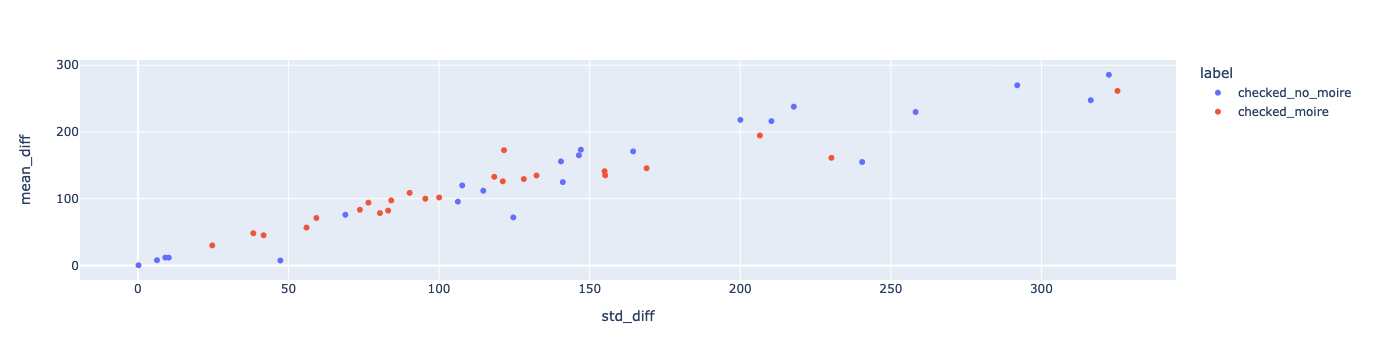

In [83]:
px.scatter(
    x=[total_diffs[i].std() for i in range(len(total_diffs)) if (total_diffs[i] is None) == False ],
    y=[total_diffs[i].mean() for i in range(len(total_diffs)) if (total_diffs[i] is None) == False ],
    color=[masks.loc[masks_selection[i]].label for i in range(len(total_diffs)) if (total_diffs[i] is None) == False ],
    labels={
        'x' : 'std_diff',
        'y' : 'mean_diff',
        'color' : 'label'
    }
)

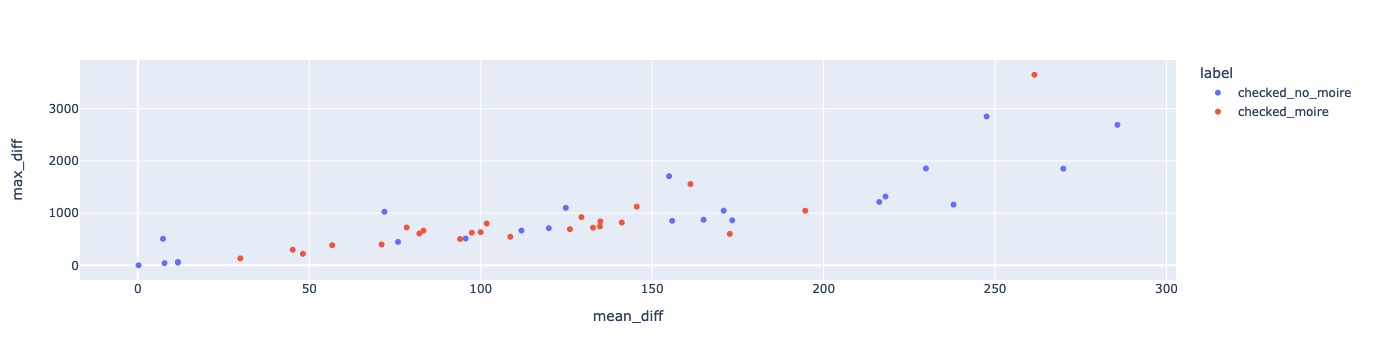

In [82]:
px.scatter(
    x=[total_diffs[i].mean() for i in range(len(total_diffs)) if (total_diffs[i] is None) == False ],
    y=[total_diffs[i].max() for i in range(len(total_diffs)) if (total_diffs[i] is None) == False ],
    color=[masks.loc[masks_selection[i]].label for i in range(len(total_diffs)) if (total_diffs[i] is None) == False ],
    labels={
        'x' : 'mean_diff',
        'y' : 'max_diff',
        'color' : 'label'
    }
)

In [ ]:
px.imshow(fft_halftone)

In [ ]:
px.imshow(fft_screen)

In [ ]:
px.imshow(fft_diff)

In [ ]:
px.imshow( fft_total_diff )

In [ ]:
halftone_tiles[i]

In [ ]:
screen_tiles[i]